# Community Solar Hardware Recommender

## Overview
Returns hardware recommendations based on a few different goals

* Fastest Possible ROI
* 7 Year ROI
* Biggest Energy Generation with ROI reached within 7 years
* Biggest Automated DR Participation with ROI reached within 7 years

### Current Gaps
* curtailment and capacity restrictions between PV and battery
* hardware inneficiencies
* is the NREL capacity factor relevent here? does that capture days of no sun?
* operational costs

## Psuedo Code

Inputs:
* Location
* Range of PV and Battery options
* Cost estimates
* Network info
* shading on an hourly basis

1) Get hourly irradiance from NREL
2) loop through every possible PV and battery combo and determine:
    * estimated hardware costs
    * estimated annual PV Wh generation (does it get curtailed if it exceeds battery capacity)?
    * maximum automated DR participation (combines battery capacity and SOA during event windows)
    * calculates ROI
3) Remove options that don't break even within 7 years from data set
4) graph all data
5) identify:
    * hardware combination with quickest ROI
    * largest PV system within 8 year ROI
    * largest Battery system within 7 year ROI
    * largest overall system within 7 year ROI
    * system with largest avoided grid consumption
    * system with largest automated DR event participation
    
## Variations to Test

* only best hardware 
    * w to wh
    * $ per wh
* only worst hardware
* afternoon call times

In [82]:
import pandas as pd
from matplotlib import pyplot as plt
import requests

In [83]:
#Max Hardware Sizes
pvMaxW = 500
batMaxWh = 2000

#80% depth of discharge for LiFePO4 batteries
LiFePOdod = .8

shading = .9

#equipment derating -> charge controller efficiency etc
equipDerating = .99

totDerating = equipDerating * shading

# check against list of hardware
inverterEfficiency = .96

#battery W to Wh ratio
batPVcapacity = .43

In [84]:
#DR variables
CSRPratePerkW = 18
DLRPratePerkW = 18

totDRratePerkW = CSRPratePerkW + DLRPratePerkW

In [85]:
#PV Installation Details
lat = 40.7128
long = 74.0060

#seasonal tilt options: summer, winter, average
season = 'summer'


In [86]:
 def pvWattsRequest(lat, season):
        
    if season == 'summer':
        s = -15
    elif season == 'winter':
        s = 15
    else:
        s = 0
        
    # api documentation: https://developer.nrel.gov/docs/solar/pvwatts/v8/#request-url
    nAzimuth = str(180); #cardinal direction
    nCapkW = str(.05); #nameplate capacity minimum 0.05*
    nLat = str(lat); #latitude
    nTilt = str(lat + s); #priotized for summer
    nLosses = str(shading * equipDerating); #derating*
    nInvEff = str(inverterEfficiency * 100); #inverter efficiency*
    nBorough = 'manhattan' #this data should come from the network list ultimately
    nTimeframe = 'hourly'
    nrelKey = 'oAhJWNZJSMfoZqx83MMOV1pYheWkAi2Z2XVn59UT'
    getURL = 'https://developer.nrel.gov/api/pvwatts/v8.json?api_key=' + nrelKey + '&azimuth=' + nAzimuth+'&system_capacity=' + nCapkW +'&losses=' + nLosses +'&array_type=1&module_type=0&inv_eff=' + nInvEff + '&tilt=' +  nTilt +'&address=' + nBorough +',ny&timeframe=' + nTimeframe

    print(getURL)
    return getURL

#we care about hourly plane of array irradiance (POA)
# we can also get hourly DC output, but we'll quickly exceed the 1000 calls an hour max...
# *doesn't impact POA

nrelData = requests.get(pvWattsRequest(lat, season)).json()['outputs']
print(nrelData)

https://developer.nrel.gov/api/pvwatts/v8.json?api_key=oAhJWNZJSMfoZqx83MMOV1pYheWkAi2Z2XVn59UT&azimuth=180&system_capacity=0.05&losses=0.891&array_type=1&module_type=0&inv_eff=96.0&tilt=25.7128&address=manhattan,ny&timeframe=hourly
{'ac_monthly': [4.918851061672645, 5.472678123865919, 6.43149139505489, 7.162870940282184, 7.717884172165149, 7.784549447499189, 8.03668922590525, 7.42740221357125, 6.748676064393747, 5.582512191169373, 4.30464296876499, 3.978382019189762], 'poa_monthly': [99.28453283688867, 113.4271423394707, 139.8238105318659, 157.0954278034364, 174.3743013294589, 179.0793805477254, 187.447175942779, 174.046604485913, 153.762133270348, 120.7742205115051, 89.90231028795884, 80.39197924040245], 'solrad_monthly': [3.202726865706086, 4.05096936926681, 4.510445501027932, 5.236514260114546, 5.624977462240609, 5.969312684924179, 6.046683094928354, 5.614406596319773, 5.125404442344935, 3.895942597145327, 2.996743676265295, 2.593289652916208], 'dc_monthly': [5.152876694483153, 5.8

In [87]:
#Annual PV Production w/ 50W module

print('Estimated outputs with 50W module (they are all different):')

#multiply this by PV module size
# DC output = annual daily sun hour average * 365 days * cc efficiency * shade losses * module W
# AC output = DC output * inverter efficiency
print('ac_annual kW NREL: ' + str(nrelData['ac_annual']))

dailyAvgRad = nrelData['solrad_annual']

#this is what we use when we calculate all our options...
dcOutputFactors = dailyAvgRad * 365 * equipDerating * shading

#convert to kW
print('ac annual kW calculated from annual average radiation: ' + str(dcOutputFactors * 50 * .001 * inverterEfficiency))

#yet another way to calculate annaul AC output
print('ac annual kW calculated from predicted monthly DC output:' + str(sum(nrelData['dc_monthly'])*inverterEfficiency))

hourlyPOA = nrelData['poa']
hourlyDC = nrelData['dc']

#print(hourlyPOA)'''

Estimated outputs with 50W module (they are all different):
ac_annual kW NREL: 75.56662982353436
ac annual kW calculated from annual average radiation: 71.37482704209482
ac annual kW calculated from predicted monthly DC output:76.33299617445172


In [88]:
# GRID ELECTRICITY COSTS
def avoidedUtilityCosts(generatedkWAC):
    supplyChargeDollarsPerkWh = .09453
    deliveryChargeDollarsPerkWh = .15653
    systemBenefitChargeDollarsPerkWh = .00520
    salesTax = .045
    gridDollarPerkW = (supplyChargeDollarsPerkWh + deliveryChargeDollarsPerkWh + systemBenefitChargeDollarsPerkWh) * (1 + salesTax)
    #print("Con Ed $ per kWh = " + str(gridDollarPerkW))

    annualAvoidedCosts = generatedkWAC * gridDollarPerkW
    
    return annualAvoidedCosts


In [89]:
# HARDWARE COSTS
def hardwareCosts(pvW, batWh):
    #variable hardware costs
    # average cost of LiFePO4 batteries currently on market
    batteryDollarPerWh = 1.0
    # average cost of PV modules per kW
    pvDollarPerW = 1.0
    mountDollarPerW = 0.5
    variableCosts = pvW * (batteryDollarPerWh + pvDollarPerW + mountDollarPerW) 

    #fixed costs
    bosCost = 10
    smartController = 100
    operatingCosts = 0
    fixedHardwareCosts = bosCost + smartController + operatingCosts

    c = fixedHardwareCosts + (pvW * pvDollarPerW) + (batWh * batteryDollarPerWh)
    return c

In [90]:
#Battery + PV generation during event windows from May through September
def maxDRParticipation(batWh, pvW):
    batteryACOutput = batWh * LiFePOdod * inverterEfficiency
    
    runningTot = 0

    #Get all the DR event window hours from May 1st (day #121) through September 30th (day # 273)
    
    for d in range(121, 274):
        drEventWindowPOA = 0
        drEventDCWh = 0
        for e in range(11,15):
            #pvW
            drHour = ((d-1)*24)+e
            drEventWindowPOA = drEventWindowPOA + hourlyPOA[drHour]
            #this gets scale because its based on a 50W module
            drEventDCWh = drEventDCWh + (hourlyDC[drHour] * (pvW/50))
        
        #this is average to an hourly basis NOT the total production during the event
        runningTot = runningTot + (drEventDCWh/4)
        
        '''
        print((drEventWindowPOA/1000)*pvW * totDerating)
        print(drEventDCWh)
        print('')
        '''
    
    numDays = 274-121
    avgEventPVWhAC = (runningTot/numDays) * inverterEfficiency
    
    return avgEventPVWhAC + batteryACOutput

maxDRParticipation(1000, 50)

796.503791372549

In [91]:
'''
maximum amount of DR participation based on sum of:
battery capacity (assumes battery is full at start of DR event)
PV generation during event
'''
'''
maxAutoParticipation= (batterykWh * .25) + (pvWatts * eventSunHours * derating)
maxAutoDRGross = maxAutoParticipation * (CSRPratePerkW + DLRPratePerkW)

maxAvoidedEnergyConsumption = annualPVWatts

'''

data = {
    'pvW':[],
    'batWh':[],
    'hardwareDollars':[],
    'annualPVkWh':[],
    'annualPVkWhAC':[],
    'avoidedCostsDollars':[],
    'maxAutoParticipation':[],
    'annualIncome':[],
    'roi':[],
    'avoidedGridCosts':[],
    'drInc':[]
}


#battery watt hour loop 50 - 2000 incrementing by 50
for b in range(1,int(batMaxWh / 50)+1):
    bWh = b * 50
    
    maxPV = min(bWh * batPVcapacity, pvMaxW)
    #pv watts loop 50-500 incrementing by 10
    for p in range(1,int(maxPV / 10)+1):
        
        pW = p * 10
        #print(p * 10)
        
        data['pvW'].append(pW)
        data['batWh'].append(bWh)
        hC = hardwareCosts(pW,bWh)
        data['hardwareDollars'].append(hC)
        pvDC = dcOutputFactors * .001 * pW
        data['annualPVkWh'].append(pvDC)
        pvAC = pvDC * inverterEfficiency
        data['annualPVkWhAC'].append(pvAC)
        avoidedCosts = avoidedUtilityCosts(pvAC)
        data['avoidedCostsDollars'].append(avoidedCosts)
        maxP = maxDRParticipation(bWh,pW)
        data['maxAutoParticipation'].append(maxP)
        drInc = ((maxP/1000)* totDRratePerkW)
        inc = avoidedCosts + drInc
        data['annualIncome'].append(inc)
        data['roi'].append(hC/inc)
        data['avoidedGridCosts'].append(avoidedCosts)
        data['drInc'].append(drInc)

#load data into a DataFrame object:
df = pd.DataFrame(data)

print(str(df.shape[0])+ ' total hardware combinations generated')

print(df.head())
print('--------------------------------------------------------')
print(df.tail())

1433 total hardware combinations generated
   pvW  batWh  hardwareDollars  annualPVkWh  annualPVkWhAC  \
0   10     50            170.0    14.869756      14.274965   
1   20     50            180.0    29.739511      28.549931   
2   10    100            220.0    14.869756      14.274965   
3   20    100            230.0    29.739511      28.549931   
4   30    100            240.0    44.609267      42.824896   

   avoidedCostsDollars  maxAutoParticipation  annualIncome        roi  \
0             3.822717             44.100758      5.410345  31.421289   
1             7.645435             49.801517      9.438289  19.071253   
2             3.822717             82.500758      6.792745  32.387498   
3             7.645435             88.201517     10.820689  21.255578   
4            11.468152             93.902275     14.848634  16.163103   

   avoidedGridCosts     drInc  
0          3.822717  1.587627  
1          7.645435  1.792855  
2          3.822717  2.970027  
3          7.6454

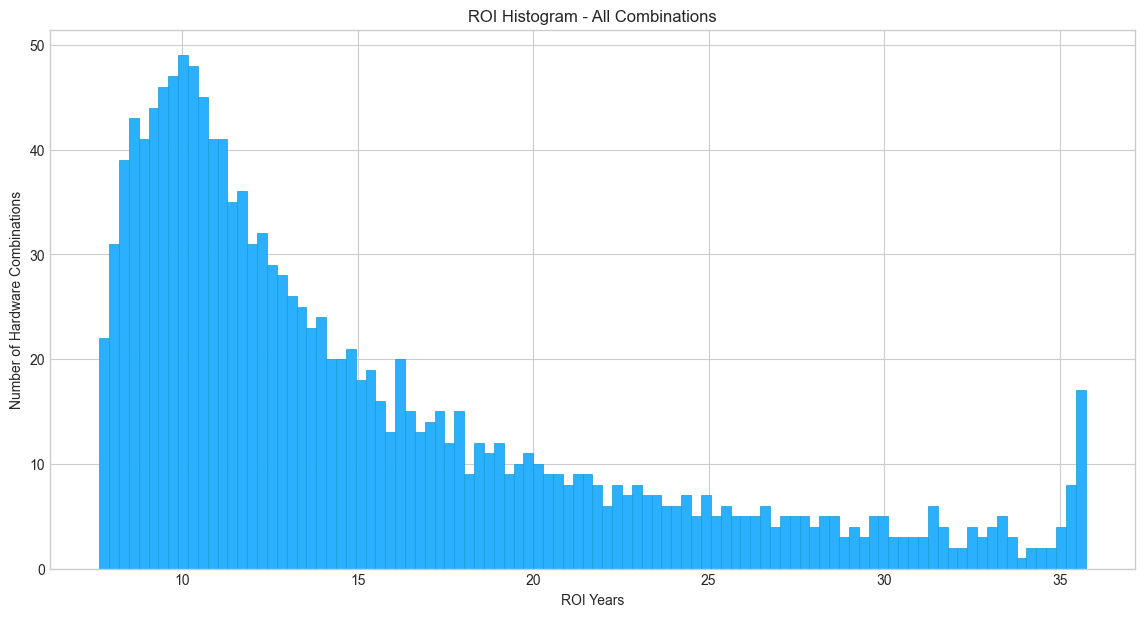

In [92]:
#ROI histogram

#n, bins, patches = plt.hist(df['roi'], 100, density=False, facecolor='g', alpha=0.75)

# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(df['roi'], bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('ROI Histogram - All Combinations') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

#style source: https://medium.com/@arseniytyurin/how-to-make-your-histogram-shine-69e432be39ca

54 hardware combinations with favorable ROI


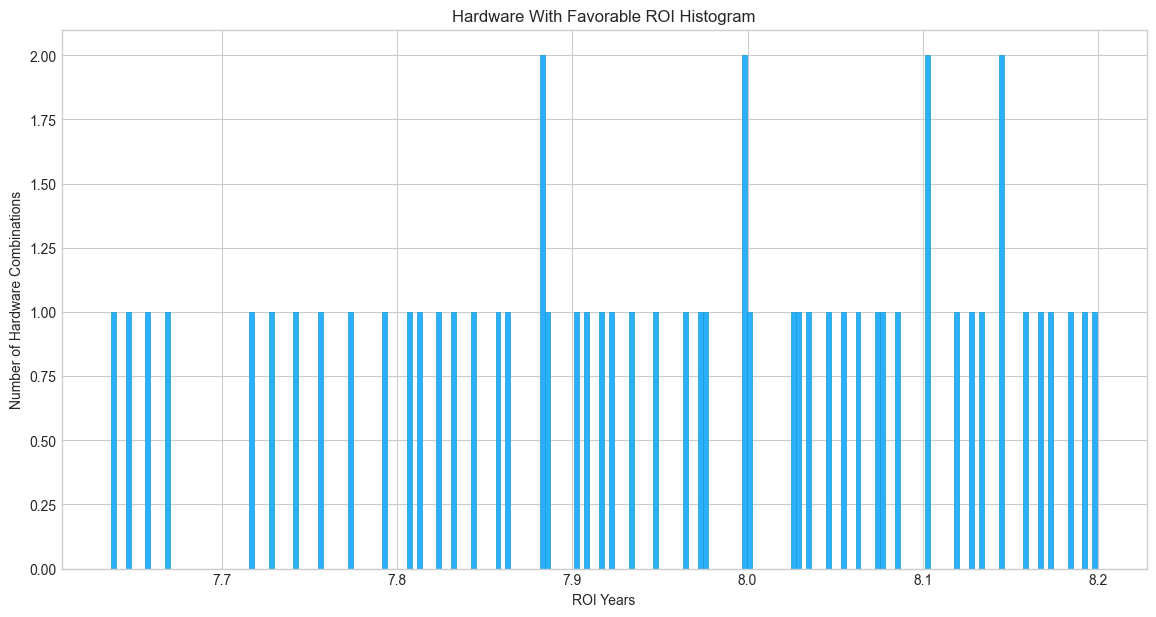

In [93]:
favROI_df = df[df['roi'] <= 8.2] 

print(str(favROI_df.shape[0])+ ' hardware combinations with favorable ROI')

# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['roi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware With Favorable ROI Histogram') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:xlabel='batWh', ylabel='pvW'>

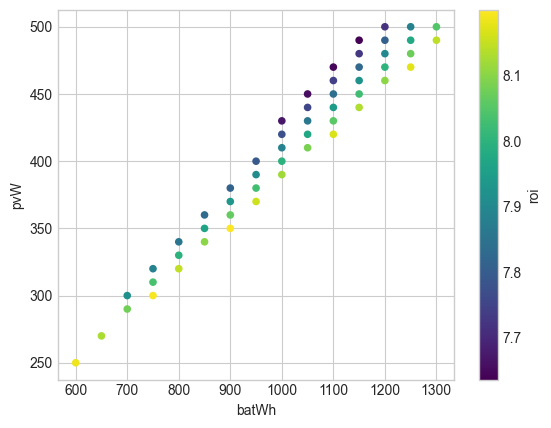

In [94]:
favROI_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='roi',colormap='viridis')

#df.show()

# df.savefig('foo.png')

# Results

### Most Favorable ROI

In [95]:
#most favorable ROI
favROI_df[favROI_df['roi'] == min(favROI_df['roi'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,avoidedCostsDollars,maxAutoParticipation,annualIncome,roi,avoidedGridCosts,drInc
582,490,1150,1750.0,728.618026,699.473305,187.313145,1162.537155,229.164483,7.636436,187.313145,41.851338


### PV System Range

In [96]:
#smallest PV system
favROI_df[favROI_df['pvW'] == min(favROI_df['pvW'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,avoidedCostsDollars,maxAutoParticipation,annualIncome,roi,avoidedGridCosts,drInc
161,250,600,960.0,371.743891,356.874135,95.567931,603.318957,117.287414,8.185021,95.567931,21.719482


In [97]:
#largest PV systems
largePV = favROI_df[favROI_df['pvW'] == max(favROI_df['pvW'])] 
largePV

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,avoidedCostsDollars,maxAutoParticipation,annualIncome,roi,avoidedGridCosts,drInc
632,500,1200,1810.0,743.487782,713.74827,191.135863,1206.637914,234.574828,7.716088,191.135863,43.438965
682,500,1250,1860.0,743.487782,713.74827,191.135863,1245.037914,235.957228,7.882785,191.135863,44.821365
732,500,1300,1910.0,743.487782,713.74827,191.135863,1283.437914,237.339628,8.047539,191.135863,46.203765


###  Battery System Range

In [98]:
#smallest Bat system
favROI_df[favROI_df['batWh'] == min(favROI_df['batWh'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,avoidedCostsDollars,maxAutoParticipation,annualIncome,roi,avoidedGridCosts,drInc
161,250,600,960.0,371.743891,356.874135,95.567931,603.318957,117.287414,8.185021,95.567931,21.719482


In [99]:
#larget bat systems
favROI_df[favROI_df['batWh'] == max(favROI_df['batWh'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,avoidedCostsDollars,maxAutoParticipation,annualIncome,roi,avoidedGridCosts,drInc
731,490,1300,1900.0,728.618026,699.473305,187.313145,1277.737155,233.311683,8.143613,187.313145,45.998538
732,500,1300,1910.0,743.487782,713.748270,191.135863,1283.437914,237.339628,8.047539,191.135863,46.203765


### Largest System

In [100]:
#largest overall system
largestSystem = largePV[largePV['batWh'] == max(largePV['batWh'])] 
largestSystem

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,avoidedCostsDollars,maxAutoParticipation,annualIncome,roi,avoidedGridCosts,drInc
732,500,1300,1910.0,743.487782,713.74827,191.135863,1283.437914,237.339628,8.047539,191.135863,46.203765


### Upfront Costs

In [101]:
#cheapest upfront cost
favROI_df[favROI_df['hardwareDollars'] == min(favROI_df['hardwareDollars'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,avoidedCostsDollars,maxAutoParticipation,annualIncome,roi,avoidedGridCosts,drInc
161,250,600,960.0,371.743891,356.874135,95.567931,603.318957,117.287414,8.185021,95.567931,21.719482


In [102]:
#most expensive upfront cost
favROI_df[favROI_df['hardwareDollars'] == max(favROI_df['hardwareDollars'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,avoidedCostsDollars,maxAutoParticipation,annualIncome,roi,avoidedGridCosts,drInc
732,500,1300,1910.0,743.487782,713.74827,191.135863,1283.437914,237.339628,8.047539,191.135863,46.203765


### DR Impact

In [103]:
#best automated DR contribution
favROI_df[favROI_df['maxAutoParticipation'] == max(favROI_df['maxAutoParticipation'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,avoidedCostsDollars,maxAutoParticipation,annualIncome,roi,avoidedGridCosts,drInc
732,500,1300,1910.0,743.487782,713.74827,191.135863,1283.437914,237.339628,8.047539,191.135863,46.203765


In [104]:
#worst DR contribution
favROI_df[favROI_df['maxAutoParticipation'] == min(favROI_df['maxAutoParticipation'])] 


,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,avoidedCostsDollars,maxAutoParticipation,annualIncome,roi,avoidedGridCosts,drInc
161,250,600,960.0,371.743891,356.874135,95.567931,603.318957,117.287414,8.185021,95.567931,21.719482


In [105]:
#ratio of DR income to avoided electricity costs
incRatio = favROI_df['avoidedGridCosts'] / favROI_df['drInc']

print('Ratio of financial benefits (avoided grid costs/ DR income')
print('Min: ' + str(min(incRatio)))
print('Max: ' + str(max(incRatio)))

      #how many DR participants are required to meet the minimum requirements?

Ratio of financial benefits (avoided grid costs/ DR income
Min: 4.064357764672194
Max: 4.506836874815841


# Discussion

Operational costs may be able to be met from the DR income after ROI has been reached

* What is the income from the point of ROI to end of life?